In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['font.family'] = "NanumGothic"
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 데이터 프레임 내 숫자 형태의 string을 int 또는 float으로 변환
def num_str2float(s):
    try:
        return pd.to_numeric(s)
    except ValueError:
        return s

# 데이터 프레임 내 string에서 특정 문자 제거 예: ',' 또는 '_'
def remove_tar_str(s, target_string):
    if isinstance(s, str):
        return s.replace(target_string, '')
    else:
        return s
    
#파일 로드 및 변환
def data_prep(file):
    df = pd.read_csv(file, encoding='utf-8') # 파일 CSV 형태로 로드
    df = df.map(lambda x: remove_tar_str(x, ',')).apply(num_str2float) #데이터 프레임 내 특정 string 제거 후 숫자 변환 수행

    df = df.drop(df.columns[9:], axis=1)
    df['거래금액(원)'] = df['거래금액(만원)']*10000
    df['전용면적(평)'] = df['전용면적(㎡)']/3.3
    df['평단가'] = df['거래금액(만원)']/df['전용면적(평)']
    return df

In [4]:
file_list = [
    'data/18.csv',
    'data/19.csv',
    'data/20.csv',
    'data/21.csv',
    'data/22.csv',
    'data/23.csv'
]
N_df = pd.DataFrame()
for file in file_list:
    df = data_prep(file)
    N_df = pd.concat([N_df, df], axis=0)

df_desc = N_df.sort_values(by=['계약년월']).groupby('계약년월').agg({'평단가': 'mean'})

In [5]:
df_desc

,평단가
계약년월,
201801,5284.683427
201802,5162.512642
201803,5559.330421
201804,5408.207363
201805,5384.022908
...,...
202307,8650.016658
202308,8627.588392
202309,8381.031394


In [6]:
N_df.to_csv("data/18~23.csv", index=True)

In [7]:
trade_volumn = N_df['계약년월'].value_counts()
trade_volumn

계약년월
202006    824
201801    794
201808    728
201910    698
201907    668
         ... 
201902     49
202212     43
202211     38
202209     32
202210     31
Name: count, Length: 71, dtype: int64

In [8]:
temp_out_df = pd.merge(df_desc, trade_volumn, left_index=True, right_index=True, how='inner')

In [9]:
#한국은행 기준 금리 데이터 파일 로드 및 변환
sample_df = pd.read_csv('data/한국은행 기준금리 및 여수신금리_2013_11-2023_11.csv', encoding='utf-8') # 파일 CSV 형태로 로드
sample_df = sample_df.map(lambda x: remove_tar_str(x, ',')).apply(num_str2float) #데이터 프레임 내 특정 string 제거 후 숫자 변환 수행
column_names = sample_df.columns
ref_inter_rate = sample_df.drop(columns=column_names[0:4], axis=1).T.rename(columns={0: "금리"})
ref_inter_rate.index = pd.to_numeric(ref_inter_rate.index.str.replace('/', ''))

In [10]:
sample_df

,통계표,계정항목,단위,변환,2013/11,2013/12,2014/01,2014/02,2014/03,2014/04,...,2023/02,2023/03,2023/04,2023/05,2023/06,2023/07,2023/08,2023/09,2023/10,2023/11
0,1.3.1. 한국은행 기준금리 및 여수신금리,한국은행 기준금리,연%,원자료,2.5,2.5,2.5,2.5,2.5,2.5,...,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5


In [11]:
ref_inter_rate

,금리
201311,2.5
201312,2.5
201401,2.5
201402,2.5
201403,2.5
...,...
202307,3.5
202308,3.5
202309,3.5
202310,3.5


In [12]:
final_out_df = pd.merge(temp_out_df, ref_inter_rate, how='inner', left_index=True, right_index=True)

In [13]:
kospi = pd.read_csv('data/kospi.csv',index_col=0)
kosdaq = pd.read_csv('data/kosdaq.csv', index_col=0)
simli_df = pd.read_csv("data/simli.csv", index_col=0)
hwan_df = pd.read_csv('data/hwan.csv', index_col=0)
sobi_df = pd.read_csv('data/sobiza.csv', index_col=0)

In [14]:
temp_df1 = pd.merge(final_out_df, kospi, how='inner', left_index=True, right_index=True)
temp_df2 = pd.merge(temp_df1, kosdaq, how='inner', left_index=True, right_index=True)
temp_df2 = temp_df2.rename(columns={"count": "volume", "0": "kospi", "1": 'kosdaq'})
temp_df3 = pd.merge(temp_df2, simli_df, how='inner', left_index=True, right_index=True)
temp_df4 = pd.merge(temp_df3, sobi_df, how='inner', left_index=True, right_index=True)
final_final_df = pd.merge(temp_df4, hwan_df, how='inner', left_index=True, right_index=True)
final_final_df.to_csv('data/completed_gangnam.csv')

In [15]:
df = pd.read_csv('data/completed_gangnam.csv', index_col=0)

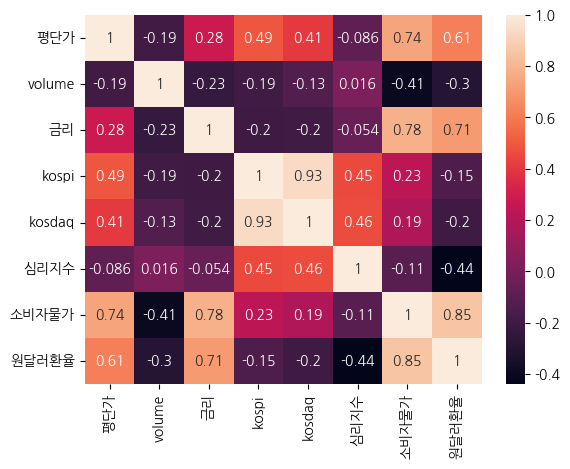

In [16]:
sns.heatmap(df.corr(), annot=True)
plt.show()

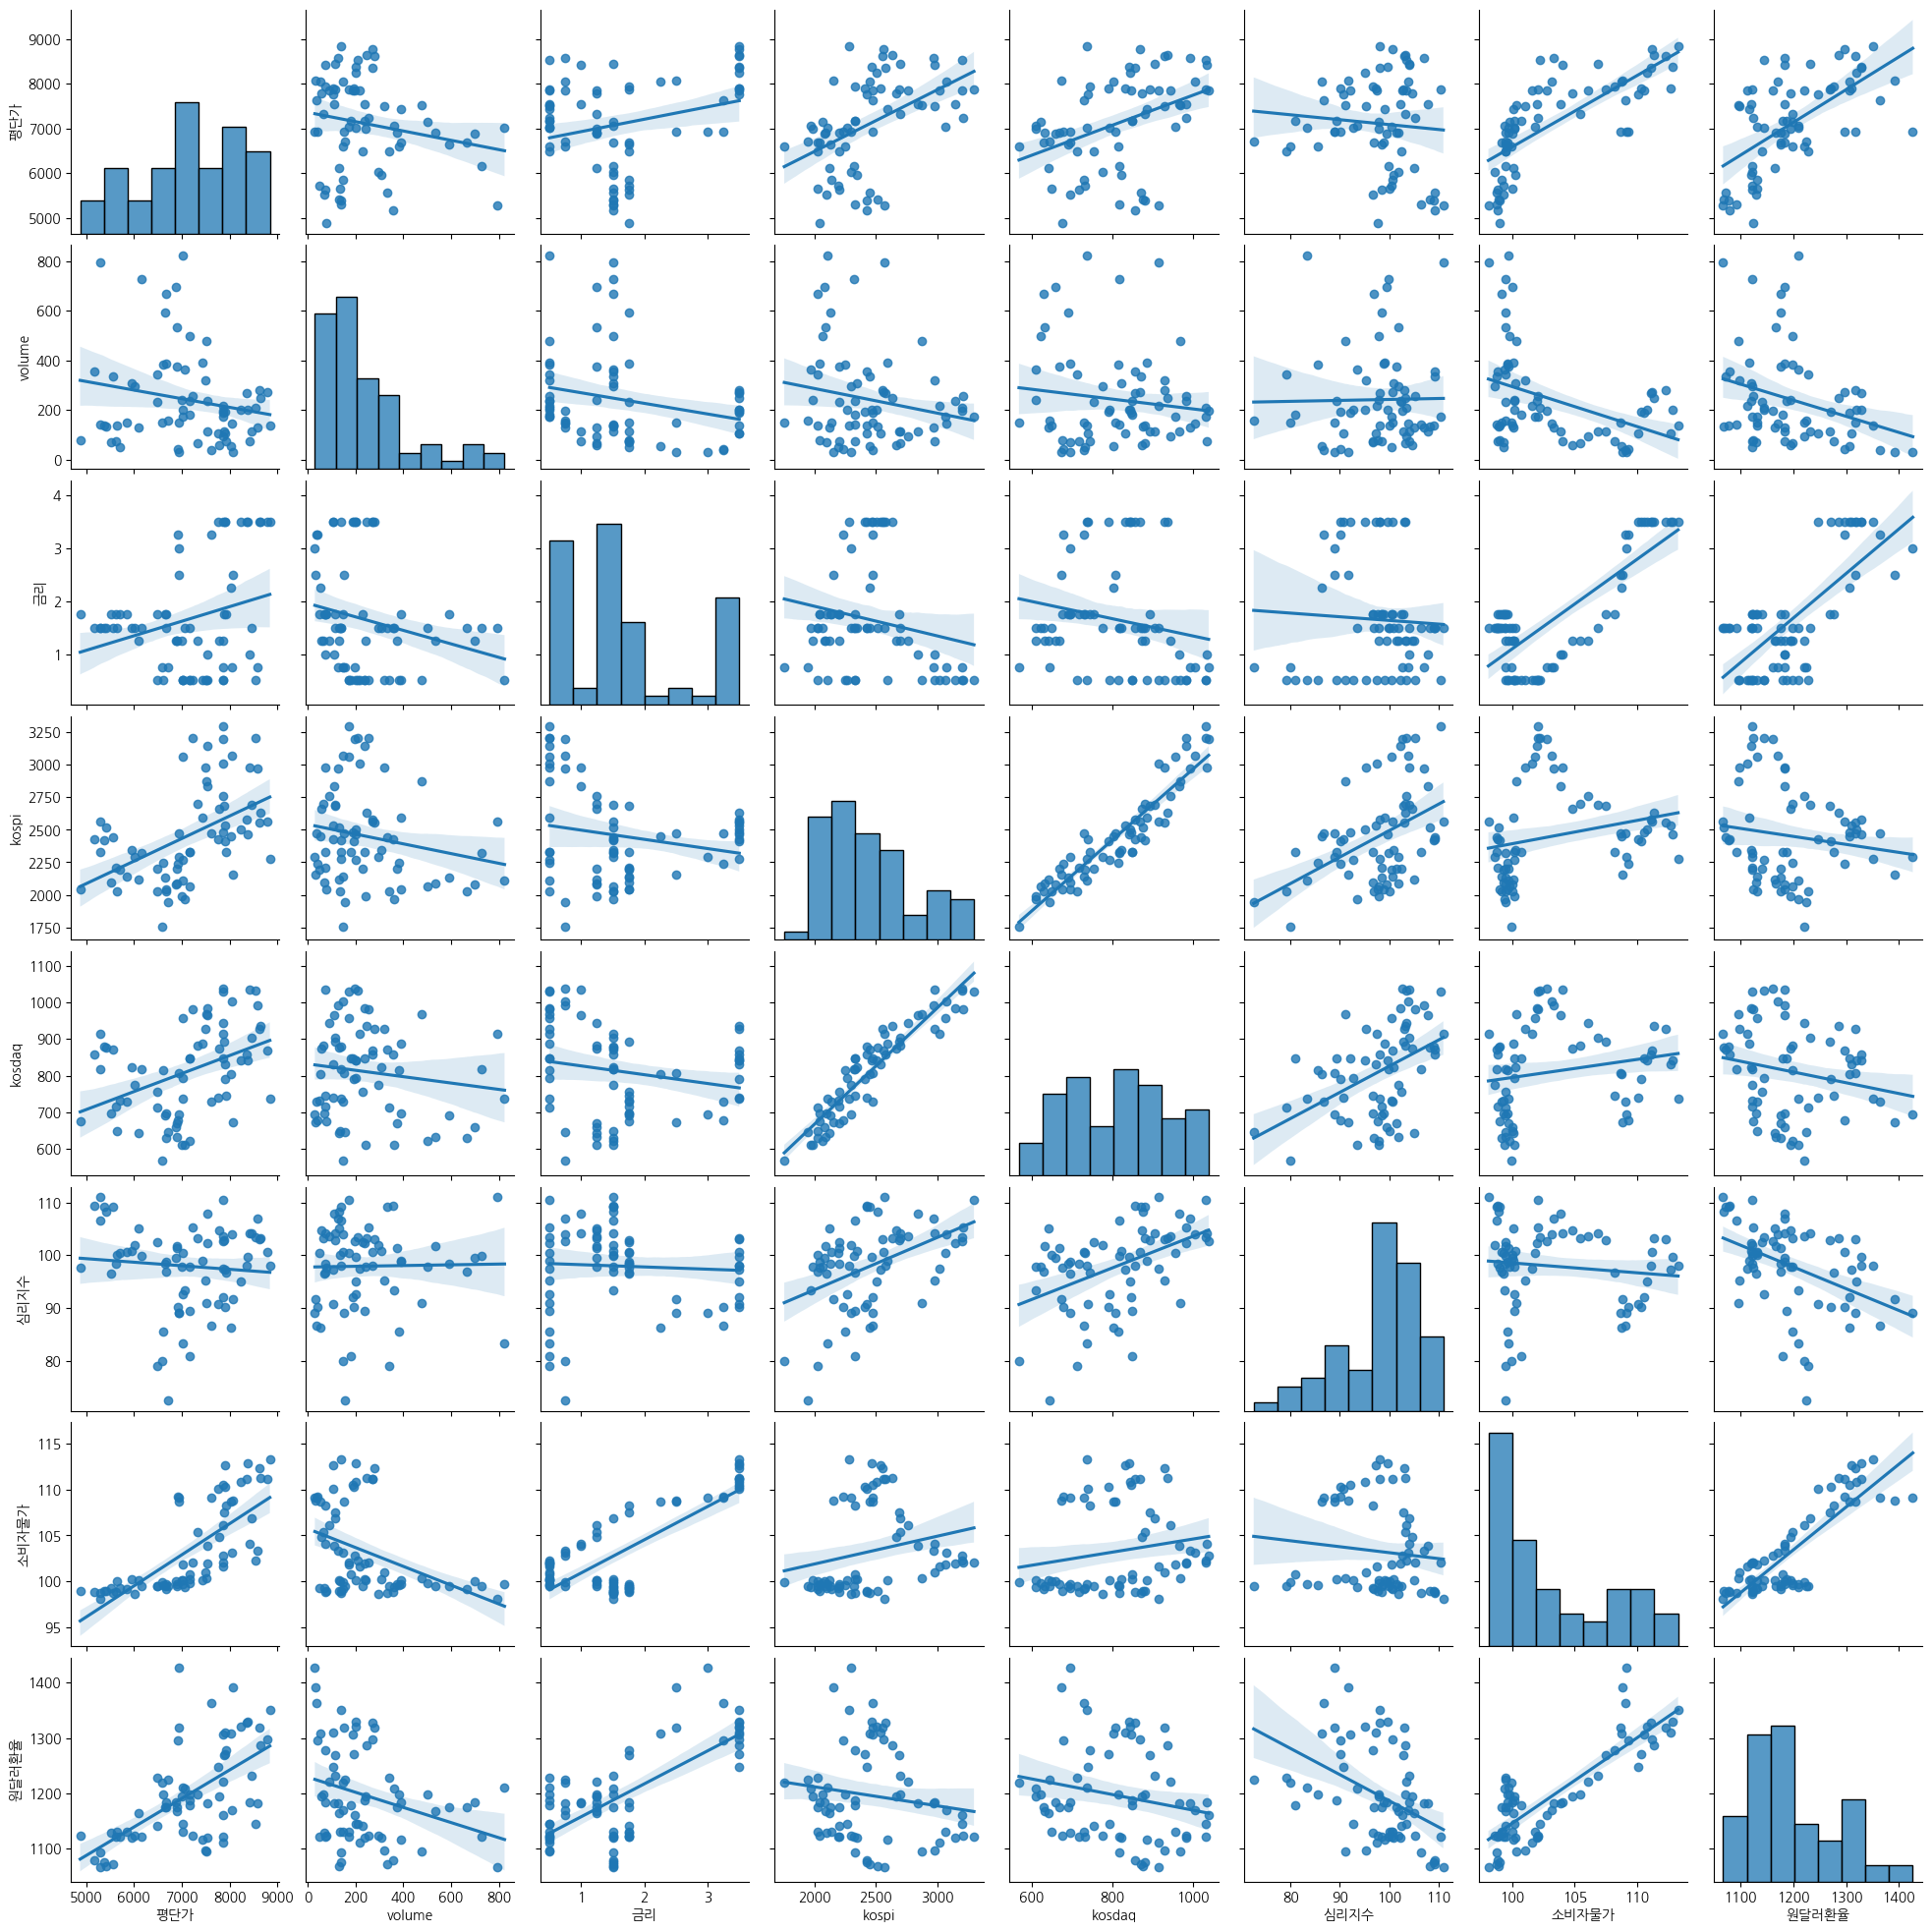

In [17]:

sns.pairplot(df, kind='reg')
